# Grover get minimal value
Here we apply the dataset as if they were a percent error of $\pi$ :
- By default a rotation of $\pi$ is apply.
- A data of $10$ implied an error of $10\%$ and so a rotation of $acos(1-(90*2/100))$ gonna be apply instead of $\pi$.

In [1]:
import math
import itertools
import numpy as np

import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram

In [2]:
# Initialize Qasm simulator backend
qasm = Aer.get_backend('qasm_simulator')
backend_sim = qasm

In [3]:
# Dataset
# The smaller the value, the more expected it is in the result.
# So here the result we expected are the last one and the before last one.
PG_i = [6, 30, 90, 30, 20, 15, 100, 0]

# Circuit vars
data = PG_i
len_qram = math.ceil(math.log2(len(data)))
len_algo = 10
#nb_interations = math.ceil((np.pi/4)*(math.sqrt(2**len_qram)))
nb_interations = 1

In [4]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$Diff$"
    return U_s

In [5]:
def ram(nb_qram, nb_algo, data):
    map_ram = list(itertools.product([0, 1], repeat=nb_qram))
    qram = QuantumRegister(nb_qram, 'qram')
    qalgo = QuantumRegister(nb_algo, 'algo')
    qc = QuantumCircuit(qram, qalgo)
        
    # Map data of the dataset here
    for d, m_ram in zip(data, map_ram):
        #qc.barrier()
        # Init binary state
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
        
        # We apply the data of the dataset as a percent error of pi.
        for algo in qalgo:
            qc.mcrx(math.acos(1-(d*2/100)), qram, algo)
        
        # Close binary state
        for index, gate in enumerate(m_ram):
            if gate == 0:
                qc.x(qram[index])
    
    U_s = qc.to_gate()
    U_s.name = "$Qram$"
    return U_s

# Show the content of the qram gate
qram = QuantumRegister(len_qram, 'qram')
qalgo = QuantumRegister(len_algo, 'algo')
qc = QuantumCircuit(qram, qalgo)
qc.append(ram(len_qram, len_algo, data), [*[i for i in range(len_qram+len_algo)]])
qc = qc.decompose(gates_to_decompose="$Qram$")
#qc = ram(len_qram, len_algo, data)
#qc.draw(output="mpl", fold=-1)

In [6]:
def algo(nqubits):
    qalgo = QuantumRegister(nqubits, 'algo')
    qc = QuantumCircuit(qalgo)
    
    # Define generic tranformation to apply for every data of the dataset here
    #qc.x(qalgo)
    
    U_s = qc.to_gate()
    U_s.name = "$Algo$"
    return U_s

# Show the content of the qalgo gate and add the oracle
qalgo = QuantumRegister(len_algo, 'algo')
qc = QuantumCircuit(qalgo)
qc.append(algo(len_algo), [*[i for i in range(len_algo)]])
qc = qc.decompose(gates_to_decompose="$Algo$")
#qc.draw(output="mpl", fold=-1)

# Here the entire algo is placed inside the QRAM,
# we don't have generic transformation to apply to every data.

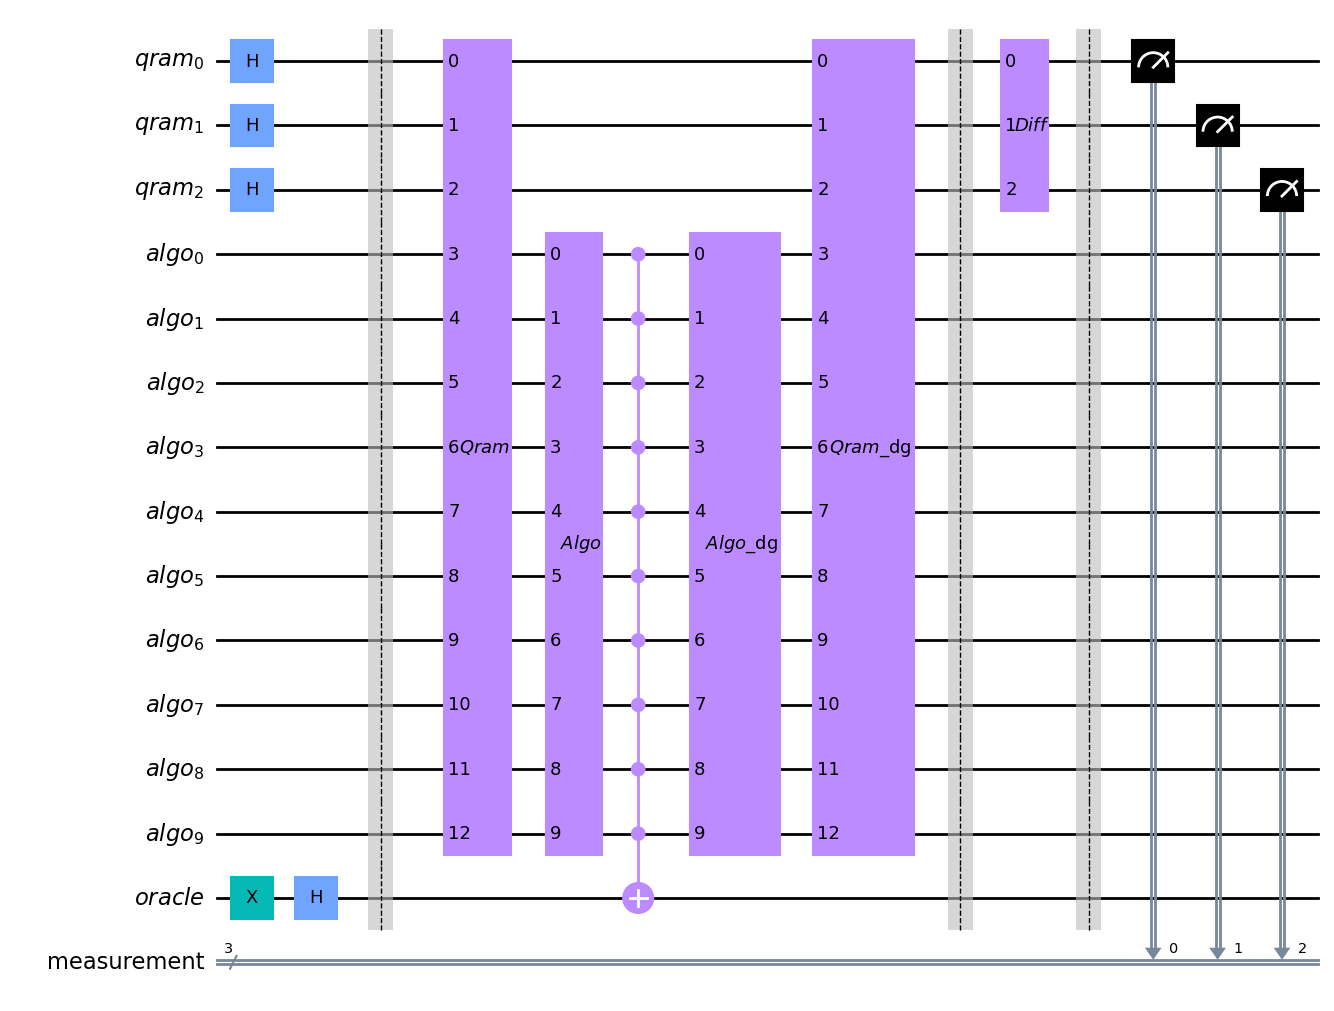

In [7]:
qram = QuantumRegister(len_qram, 'qram')
qalgo = QuantumRegister(len_algo, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(len_qram, 'measurement')

qc = QuantumCircuit(qram, qalgo, oracle, c)

# Init
qc.h(qram)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# Qram + Algorithm
for interation in range(nb_interations):
    qc.append(ram(len_qram, len_algo, data), [*[i for i in range(len_qram+len_algo)]])
    qc.append(algo(len_algo), [*[i for i in range(len_qram, len_qram+len_algo)]])

    # Oracle
    qc.mcx(qalgo, oracle)

    # Revert Algo + Qram
    qc.append(algo(len_algo).inverse(), [*[i for i in range(len_qram, len_qram+len_algo)]])
    qc.append(ram(len_qram, len_algo, data).inverse(), [*[i for i in range(len_qram+len_algo)]])
    qc.barrier()

# Diffuser
qc.append(diffuser(len_qram), [*[i for i in range(len_qram)]])

# Measure of the ouputs
qc.barrier()
qc.measure(qram, c)

qc.draw(output="mpl", fold=-1)

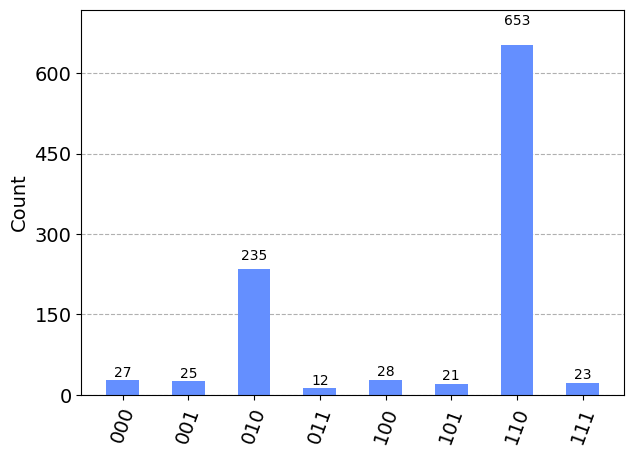

In [8]:
qc = qc.reverse_bits()
job = execute(qc, backend_sim, shots=1024)
result_job = job.result()
result_count = result_job.get_counts()
plot_histogram(result_count)

In [9]:
result_sort = sorted(result_count.items(), key=lambda x: x[1], reverse=True)
print([key for key, value in result_sort[:2]])

['110', '010']


In [11]:
qc_decom = qc.decompose()
qc_decom.depth()

1949

In [9]:
import qiskit.tools.jupyter
%qiskit_version_table